In [1]:
import numpy as np
import pandas as pd
import os
import sys
import torch
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')

import torchvision
import torchvision.transforms as T

%matplotlib inline
%load_ext autoreload
%autoreload 2

sys.path.append('../')

from utils import tonp
import utils

torch.set_grad_enabled(False)
device = torch.device('cuda')

import matplotlib
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["figure.facecolor"] = 'white'

## Loading task encoder and retrieving tasks

In [2]:
TASK_TYPE = 'resnet18_d8' # mlp, vit, resnet18 or resnet18_d8
PATH = os.path.abspath(f"../checkpoints/checkpoint_{TASK_TYPE}.ckpt")

In [ ]:
from models.as_uniformity import ASUniformityTraining

model = ASUniformityTraining.load_from_checkpoint(PATH)
model.to(device)
model.eval();

In [4]:
trainloader = model.data_module.train_dataloader(batch_size=512, drop_last=False)

In [5]:
xs, idxs, logits, tasks = [], [], [], []
for batch in trainloader:
    l = model.logits_all_tasks(batch[0].to(model.device)).cpu()
    t = (l > 0).long()
    xs.append(batch[0])
    idxs.append(batch[2])
    logits.append(l)
    tasks.append(t)


xs, idxs, logits, tasks = map(lambda a: torch.cat(a), [xs, idxs, logits, tasks])

## Visualize top k images from each task/class

In [6]:
val_botk, idx_botk = (-logits).topk(20,dim=0)
val_topk, idx_topk = logits.topk(20,dim=0)

In [7]:
# Agreement score calculated on the architecture as task-net. E.g., if task-net=mlp then agreement score calculated using mlp architectures.
as_table = pd.read_csv('../assets/tasks/agreement_table.csv')
as_table = as_table[as_table['task'] == TASK_TYPE]

if len(as_table) > 0:
    as_table = as_table.drop(columns=['task'])
    as_table = as_table.set_index('task_idx')
else:
    as_table = None

In [8]:
def vis_topk(idx_topk, idxbotk,renorm=True, as_table=None):
    nb_tasks = tasks.size(1)
    mean = torch.FloatTensor([x / 255.0 for x in [125.3, 123.0, 113.9]])[None, :, None, None]
    std = torch.FloatTensor([x / 255.0 for x in [63.0, 62.1, 66.7]])[None, :, None, None]

    if renorm:
        xs_viz = xs * std + mean
    else:
        xs_viz = xs

    fig,ax = plt.subplots(nb_tasks, 2, figsize=(2*7, nb_tasks*2))


    for tid in range(nb_tasks):
        img_grid = torchvision.utils.make_grid(xs_viz[idx_topk[:,tid]],nrow=10)
        ax[tid,0].imshow(img_grid.permute(1,2,0))
        img_grid = torchvision.utils.make_grid(xs_viz[idx_botk[:,tid]],nrow=10)
        ax[tid,1].imshow(img_grid.permute(1,2,0))
        ylabel = f'task {tid}'
        if as_table is not None: ylabel += f'\nAS={as_table.loc[tid]["as"]:.2f}'
        ax[tid,0].set_ylabel(ylabel, fontsize=15)

    ax[0,0].set_title('class 1', size=20)
    ax[0,1].set_title('class 0', fontsize=20)

    for i in range(nb_tasks):
        ax[i,0].grid(False)
        ax[i,0].set_yticklabels([])
        ax[i,0].set_xticklabels([])
        ax[i,1].axis("off")

    plt.tight_layout()

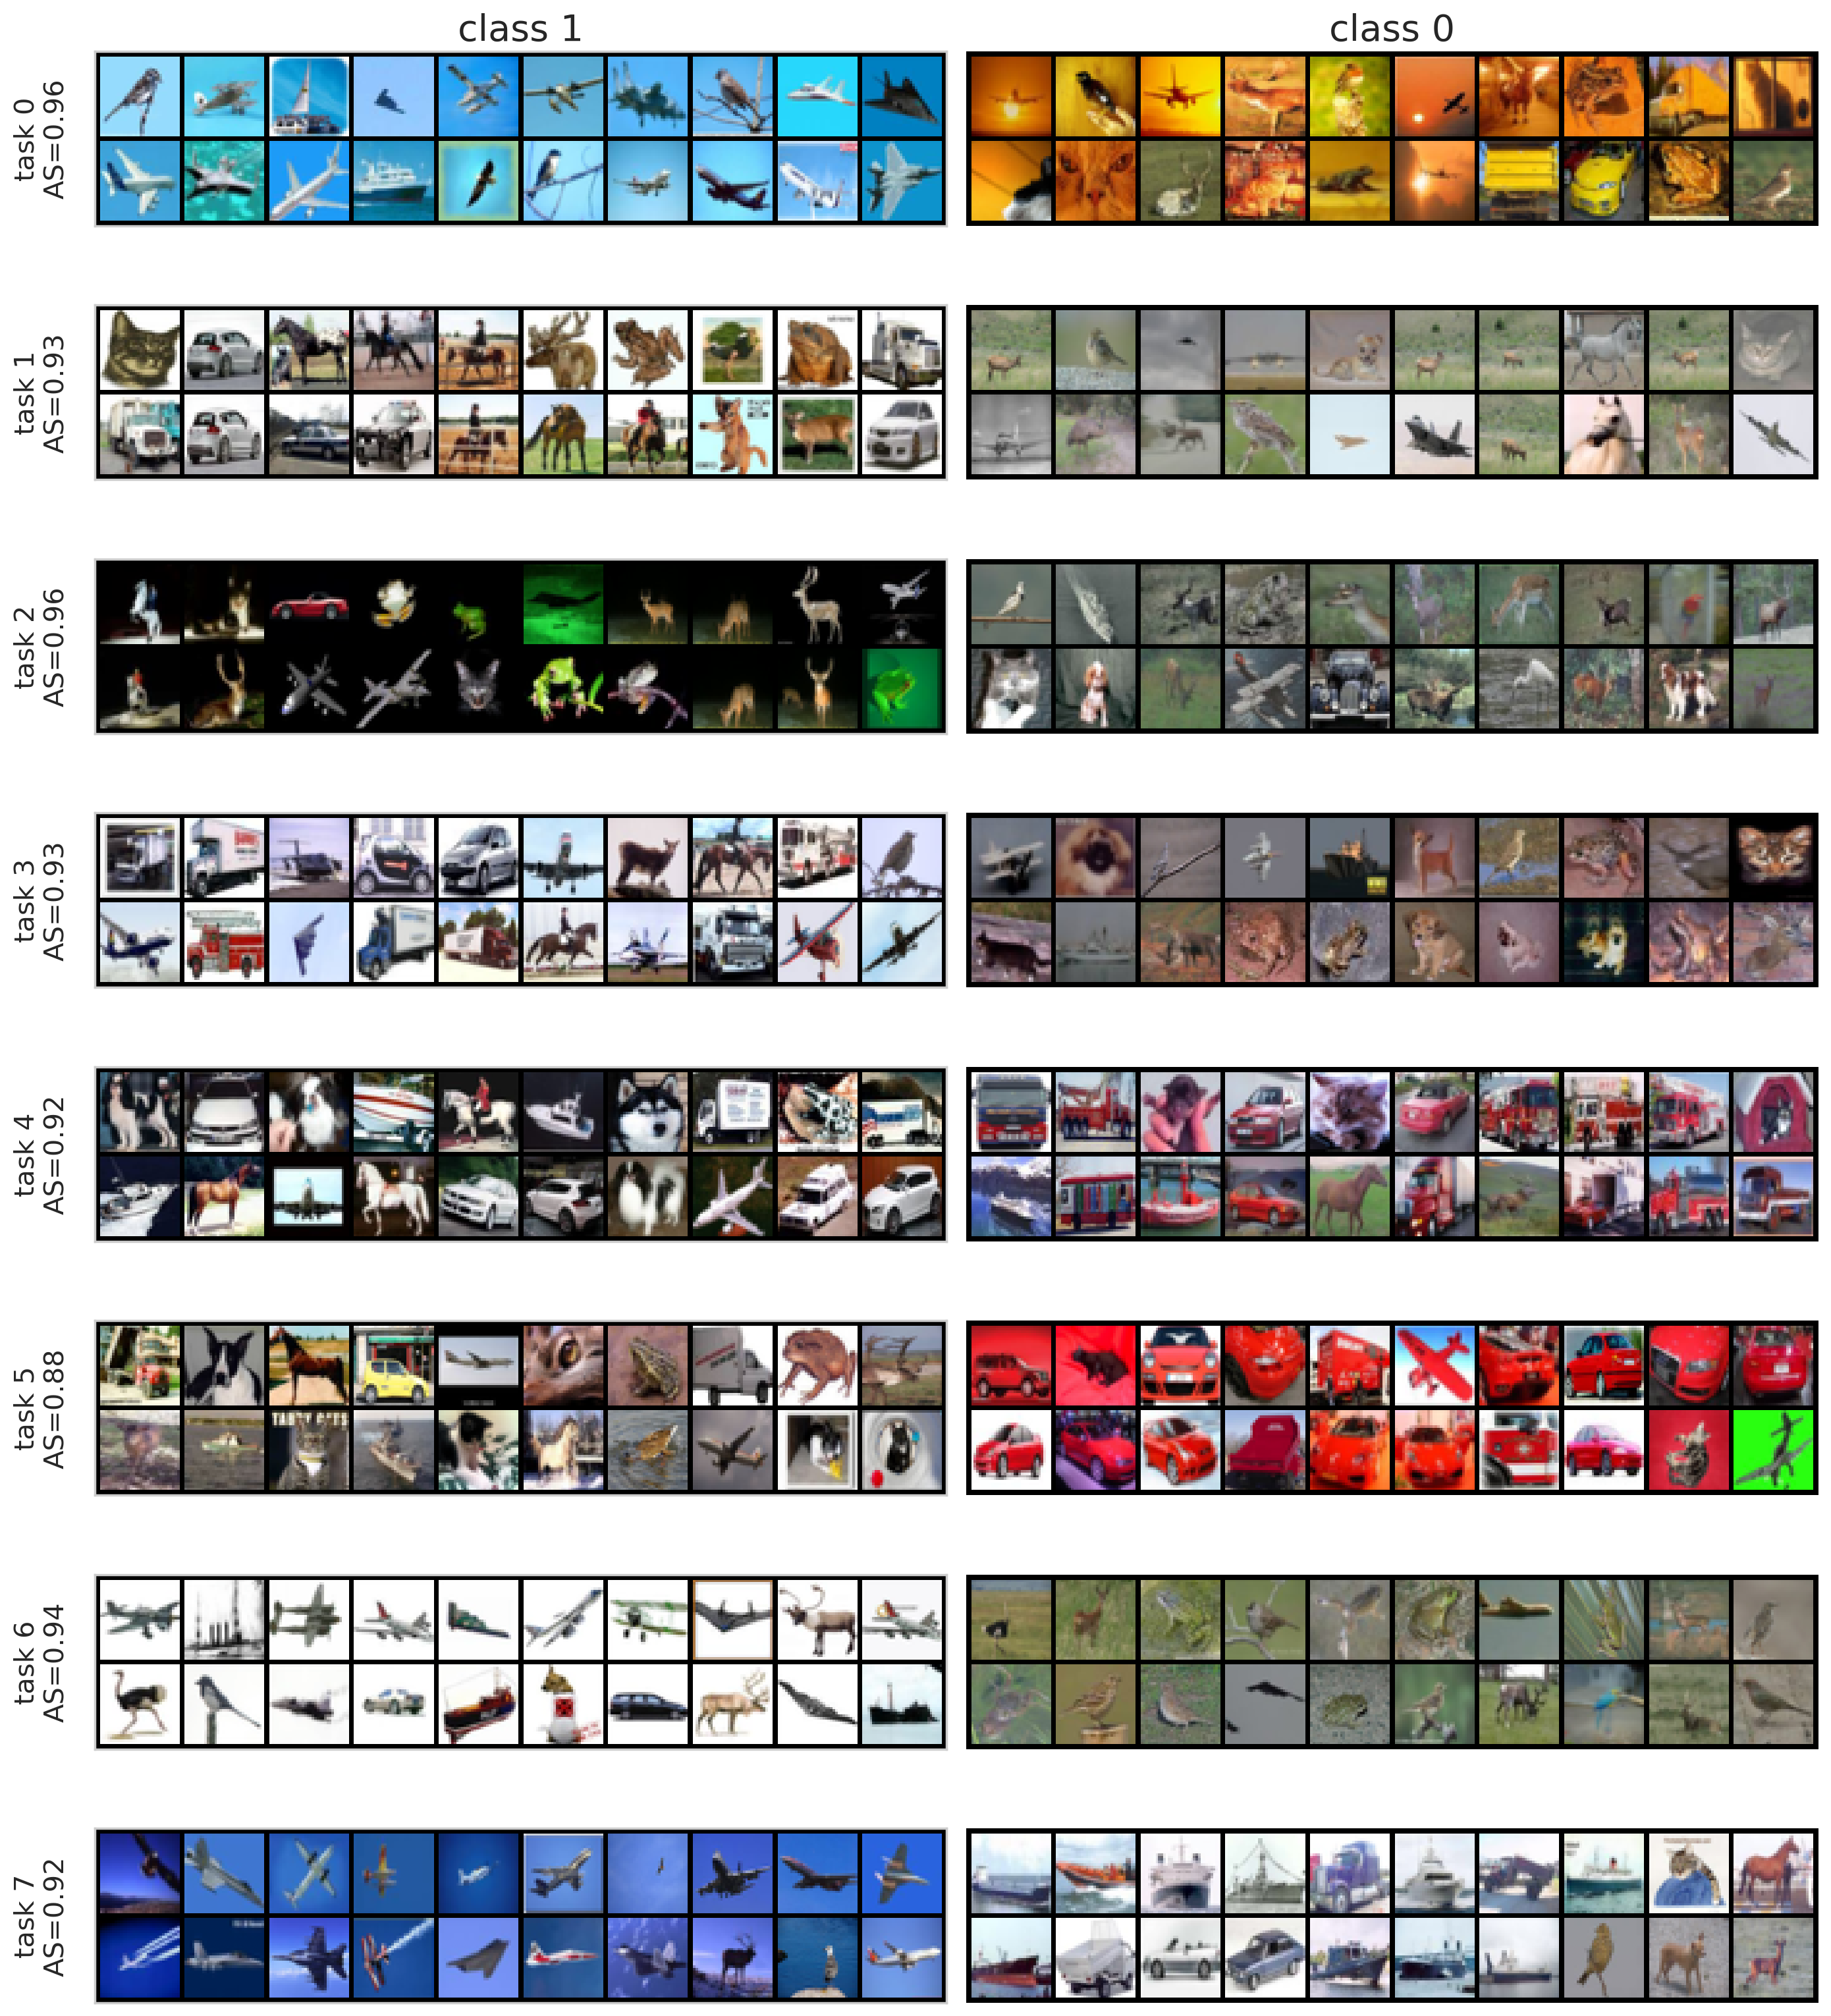

In [9]:
vis_topk(idx_topk, idx_botk, as_table=as_table)